# Get cell states vs storage for all ResOps reservoirs

In [2]:
import os
print(f'Old working directory: {os.getcwd()}')
# change directory out of subdirectory 'experiments'
os.chdir('..')
print(f'Current working directory: {os.getcwd()}')

Old working directory: c:\Users\mattc\Documents\DL-reservoir-modeling\experiments
Current working directory: c:\Users\mattc\Documents\DL-reservoir-modeling


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from math import floor
import seaborn as sns
from scipy import stats
from scipy.stats import theilslopes
import os
import copy

from src.data.data_processing import *
from src.data.data_fetching import *
from src.models.model_zoo import *
from src.models.predict_model import *
from src.models.train_model import *
from src.data.implied_storage import get_implied_storage
from src.models.analyze_lstm_cell import *


## Compare Performance on ResOps
For manual unroll Model 1-4

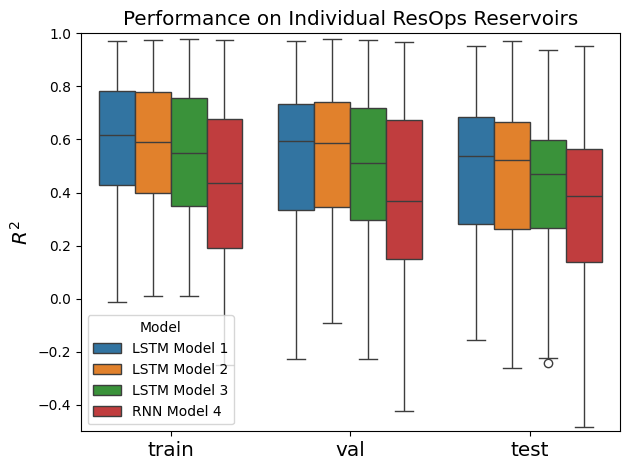

In [3]:
# Compare with benchmark scores
r2_scores_model1 = pd.read_csv('report/results/resops_training/resops_unroll_models/resops_unroll_model1_r2.csv', index_col=0)
r2_scores_model2 = pd.read_csv('report/results/resops_training/resops_unroll_models/resops_unroll_model2_r2.csv', index_col=0)
r2_scores_model3 = pd.read_csv('report/results/resops_training/resops_unroll_models/resops_unroll_model3_r2.csv', index_col=0)
r2_scores_model4 = pd.read_csv('report/results/resops_training/resops_unroll_models/resops_unroll_model4_r2.csv', index_col=0)

# Convert to long format
r2_scores_model1 = r2_scores_model1.melt(value_vars=['train', 'val', 'test'])
r2_scores_model2 = r2_scores_model2.melt(value_vars=['train', 'val', 'test'])
r2_scores_model3 = r2_scores_model3.melt(value_vars=['train', 'val', 'test'])
r2_scores_model4 = r2_scores_model4.melt(value_vars=['train', 'val', 'test'])

# Add model type
r2_scores_model1['Model'] = 'LSTM Model 1'
r2_scores_model2['Model'] = 'LSTM Model 2'
r2_scores_model3['Model'] = 'LSTM Model 3'
r2_scores_model4['Model'] = 'RNN Model 4'

# Concat and plot
r2_scores_unroll = pd.concat([r2_scores_model1, r2_scores_model2, r2_scores_model3, r2_scores_model4], axis=0)

fig, ax = plt.subplots()
bp = sns.boxplot(data=r2_scores_unroll, x='variable', y='value', hue='Model')
ax.set_title('Performance on Individual ResOps Reservoirs', size='x-large')
ax.set_ylabel('$R^2$', size='x-large')
ax.set_xlabel('')
plt.setp(ax.get_xticklabels(), size='x-large')
plt.ylim(-0.5, 1)
plt.tight_layout()
plt.savefig('report/drafting/8_15_2025/Figures/individual_lstm_unroll_resops.png', dpi=300)
plt.show()

## Get storage correlations

In [4]:
def get_left_years(res_list):
    """ 
    Get left data window years (first record year after leading NA) for each reservoir ID in res_list.
    Return results as dictionary
    Params:
    res_list -- list of ResOPS ID's to fetch left years for
    """
    # For each filtered reservoir, find first year of avail record after leading NA (left year window)
    left_years_dict = {}
    for res in res_list:
        left_years_dict[res] = resops_fetch_data(res_id=res, 
                                                vars=['inflow', 'outflow', 'storage']).isna().idxmin().max().year
    return left_years_dict

def data_processing(res_id, transform_type, left, right='2020-12-31', train_frac=0.6, val_frac=0.2, test_frac=0.2, return_scaler=False, storage=False):
    """
    Run data processing pipeline for one ResOPS reservoir.
    Params:
    res_id -- int, ResOPS reservoir ID
    transform_type -- str, in preprocessing, whether to 'standardize' or 'normalize' the data
    left -- str (YYYY-MM-DD), beginning boundary of time window
    right -- str (YYYY-MM-DD), end boundary of time window
    return_scaler -- bool, whether or not to return src.data.data_processing.time_scaler() object
    storage -- bool, whether or not to include storage data in features
    """

    # Read in data, columns are [inflow, outflow, storage]
    df = resops_fetch_data(res_id=res_id, vars=['inflow', 'outflow', 'storage'])
    # Add day of the year (doy) as another column
    df['doy'] = df.index.to_series().dt.dayofyear
    # Select data window
    df = df[left:right].copy()

    # Run data processing pipeline
    pipeline = processing_pipeline(train_frac=train_frac, val_frac=val_frac, test_frac=test_frac, chunk_size=3*365, pad_value=-1, transform_type=transform_type, fill_na_method='mean')
    # Train/val/test tensors of shape (#chunks, chunksize, [inflow, outflow, storage, doy])
    ts_train, ts_val, ts_test = pipeline.process_data(df) 

    # Separate inputs(X) and targets (y)
    if storage:
        X_train, X_val, X_test = ts_train[:, :, [0, 2, 3]], ts_val[:, :, [0, 2, 3]], ts_test[:, :, [0, 2, 3]]
    else:
        X_train, X_val, X_test = ts_train[:, :, [0, 3]], ts_val[:, :, [0, 3]], ts_test[:, :, [0, 3]]
    # select outflow as target feature
    y_train, y_val, y_test = ts_train[:, :, [1]], ts_val[:, :, [1]], ts_test[:, :, [1]]

    if return_scaler:
        return (X_train, y_train), (X_val, y_val), (X_test, y_test), pipeline.scaler
    else:
        return (X_train, y_train), (X_val, y_val), (X_test, y_test)

def split_df_data(res_id, left, right='2020-12-31', data_splits=(0.6, 0.2, 0.2)):
    """
    Fetch original df data for one ResOPS reservoir in given time window, split into train/val/test portions.
    Params:
    res_id -- int, ResOPS reservoir ID
    left -- str (YYYY-MM-DD), beginning boundary of time window
    right -- str (YYYY-MM-DD), end boundary of time window
    data_splits -- tuple of floats, (train_frac, val_frac, test_frac) for data splits
    """
    # Read in data, columns are [inflow, outflow, storage]
    df = resops_fetch_data(res_id=res_id, vars=['inflow', 'outflow', 'storage'])
    # Select data window
    df = df[left:right].copy()

    if data_splits is not None:
        assert sum(data_splits) == 1.0, "data_splits must sum to 1.0"

        # Lengths of train/val/test sets
        original_train_len = int(round(df.shape[0] * data_splits[0]))
        original_val_len = int(round(df.shape[0] * data_splits[1]))
        original_test_len = df.shape[0] - (original_train_len + original_val_len)

        # Get data, shape is (timesteps, )
        df_train = df.iloc[:original_train_len, :]
        df_val = df.iloc[original_train_len:(original_train_len+original_val_len), :]
        df_test = df.iloc[(original_train_len+original_val_len):, :]

        return df_train, df_val, df_test

def load_resops_model(res_id, model_num=1):
    """ 
    Load trained manual unroll LSTM (Model 1-4) for one ResOPS reservoir
    Params:
    res_id -- int, ResOPS reservoir ID
    model_num -- int, which manual unroll model to load (1-4)
    """
    input_size = 2 # inflow, doy

    if model_num == 1: # Model 1 (manual unroll)
        hidden_size1 = 30
        hidden_size2 = 15
        output_size = 1 # outflow
        dropout_prob = 0.3
        num_layers = 1

        torch.manual_seed(0)
        model = LSTMModel1(input_size=input_size, hidden_size1=hidden_size1, 
                                    hidden_size2=hidden_size2, output_size=output_size, num_layers=num_layers, dropout_prob=dropout_prob)
    
    elif model_num == 2:
        hidden_size1 = 35
        hidden_size2 = 20
        num_layers = 1
        output_size = 1
        dropout_prob = 0.3

        torch.manual_seed(0)
        model = LSTMModel2(input_size=input_size, hidden_size1=hidden_size1, 
                                    hidden_size2=hidden_size2, num_layers=num_layers, output_size=output_size, dropout_prob=dropout_prob, initial_output=0)
    
    elif model_num == 3:
        hidden_size1 = 35
        hidden_size2 = 15
        num_layers = 1
        output_size = 1
        dropout_prob = 0.3

        torch.manual_seed(0)
        model = LSTMModel3(input_size=input_size, hidden_size1=hidden_size1, 
                                    hidden_size2=hidden_size2, output_size=output_size, num_layers=num_layers, dropout_prob=dropout_prob, initial_output=0, initial_implied_storage=0)
    
    elif model_num == 4:
        hidden_size = 50
        output_size = 1
        dropout_prob = 0.7
        torch.manual_seed(0)
        model = resRNN(input_size=input_size, hidden_size=hidden_size, output_size=output_size,
                    dropout_prob=dropout_prob)
    
    # Load model weights
    model.load_state_dict(torch.load(f'src/models/saved_models/resops_unroll_models/resops_model{model_num}_{res_id}.pt', weights_only=True))
    model.eval()
    return model

In [ ]:
def correlate_cell_storage():
    """ 
    For Model 1 and Model 2, for each ResOPS reservoir, correlate each LSTM cell state with observed storage in train/val/test sets. Save all results as csv.
    """
    # Get list of reservoirs and left data years
    res_list = filter_res()
    left_years_dict = get_left_years(res_list=res_list)

    model_num_list = [1, 2]
    for model_num in model_num_list:
        # Initialize empty dataframes to store correlation results
        df_corr_train = pd.DataFrame(columns=res_list)
        df_corr_val = pd.DataFrame(columns=res_list)
        df_corr_test = pd.DataFrame(columns=res_list)

        for res in tqdm(res_list, desc=f'Processing reservoirs for model {model_num}'):
            # Get split df data
            df_train, df_val, df_test = split_df_data(res_id=res, left=f'{left_years_dict[res]}-01-01', data_splits=(0.6, 0.2, 0.2))

            # Data processing
            (X_train, y_train), (X_val, y_val), (X_test, y_test) = data_processing(res_id=res, transform_type='standardize',
                                                                left=f'{left_years_dict[res]}-01-01', return_scaler=False, storage=False)

            # Load trained model
            model = load_resops_model(res_id=res, model_num=model_num)
            
            # Get hidden and cell states, result is list with one tensor for each layer, shape is (# chunks, timesteps, hidden size)
            with torch.no_grad():
                hidden_train, cell_train = model(X_train)[1]
                hidden_val, cell_val = model(X_val)[1]
                hidden_test, cell_test = model(X_test)[1]

            # Calculate correlations
            df_corr_train.loc[:, res] = cell_correlations(cell_states=cell_train[0], storage_states=df_train.storage.values)
            df_corr_val.loc[:, res] = cell_correlations(cell_states=cell_val[0], storage_states=df_val.storage.values)
            df_corr_test.loc[:, res] = cell_correlations(cell_states=cell_test[0], storage_states=df_test.storage.values)

        # Save results as csv
        df_corr_train.to_csv(f'report/results/resops_training/resops_unroll_models/cell_storage_correlations/cell_storage_corr_model{model_num}_train.csv')
        df_corr_val.to_csv(f'report/results/resops_training/resops_unroll_models/cell_storage_correlations/cell_storage_corr_model{model_num}_val.csv')
        df_corr_test.to_csv(f'report/results/resops_training/resops_unroll_models/cell_storage_correlations/cell_storage_corr_model{model_num}_test.csv')

    return

correlate_cell_storage()

Processing reservoirs for model 2: 100%|██████████| 116/116 [00:36<00:00,  3.20it/s]


In [5]:
df_corr_test_model1 = pd.read_csv('report/results/resops_training/resops_unroll_models/cell_storage_correlations/cell_storage_corr_model1_test.csv', index_col=0)
df_corr_test_model2 = pd.read_csv('report/results/resops_training/resops_unroll_models/cell_storage_correlations/cell_storage_corr_model2_test.csv', index_col=0)

# Maximum absolute correlations on test data
df_corr_max_test = pd.DataFrame({'Model1': df_corr_test_model1.abs().max(axis=0), 'Model2': df_corr_test_model2.abs().max(axis=0)})

df_corr_max_test.describe()

,Model1,Model2
count,116.000000,116.000000
mean,0.535872,0.549963
std,0.220944,0.212601
min,0.036819,0.087158
25%,0.372240,0.385375
50%,0.555613,0.571719
75%,0.707795,0.702952
max,0.954176,0.980682


### Exploratory: plot storage vs. cell state for reservoir with highest max (1883)

In [6]:
df_corr_max_test.idxmax()

Model1    1883
Model2    1883
dtype: object

In [7]:
# Plot storage vs. cell for highest correlation (reservoir 1883)
res_list = filter_res()
left_years_dict = get_left_years(res_list=res_list)
# Get split df data
df_train, df_val, df_test = split_df_data(res_id='1883', left=f'{left_years_dict['1883']}-01-01', data_splits=(0.6, 0.2, 0.2))
# Data processing
(X_train, y_train), (X_val, y_val), (X_test, y_test) = data_processing(res_id='1883', transform_type='standardize',
                                                    left=f'{left_years_dict['1883']}-01-01', return_scaler=False, storage=False)

# Load trained model
model1_1883 = load_resops_model(res_id='1883', model_num=1)

# Get hidden and cell states, result is list with one tensor for each layer, shape is (# chunks, timesteps, hidden size)
with torch.no_grad():
    hidden_train, cell_train = model1_1883(X_train)[1]
    hidden_val, cell_val = model1_1883(X_val)[1]
    hidden_test, cell_test = model1_1883(X_test)[1]

# Calculate correlations for layer 1
correlation_data = {'training':cell_correlations(cell_states=cell_train[0], storage_states=df_train.storage.values),
                    'validation': cell_correlations(cell_states=cell_val[0], storage_states=df_val.storage.values),
                    'testing': cell_correlations(cell_states=cell_test[0], storage_states=df_test.storage.values)}
df_corr = pd.DataFrame(correlation_data)

# Select cell with |correlation| > 0.90
df_corr.loc[np.abs(df_corr['testing']) > 0.90, :].sort_values(by='testing', ascending=False)


,training,validation,testing
8,0.948839,0.922021,0.951686
7,0.957141,0.940439,0.951447
11,0.945294,0.942215,0.944302
25,0.956669,0.941037,0.942063
19,0.922187,0.915420,0.939702
3,0.906634,0.882678,0.919604
29,0.892328,0.852498,0.916475
18,0.893948,0.845429,0.910534
6,-0.934824,-0.941089,-0.905568
0,-0.906187,-0.925849,-0.912629


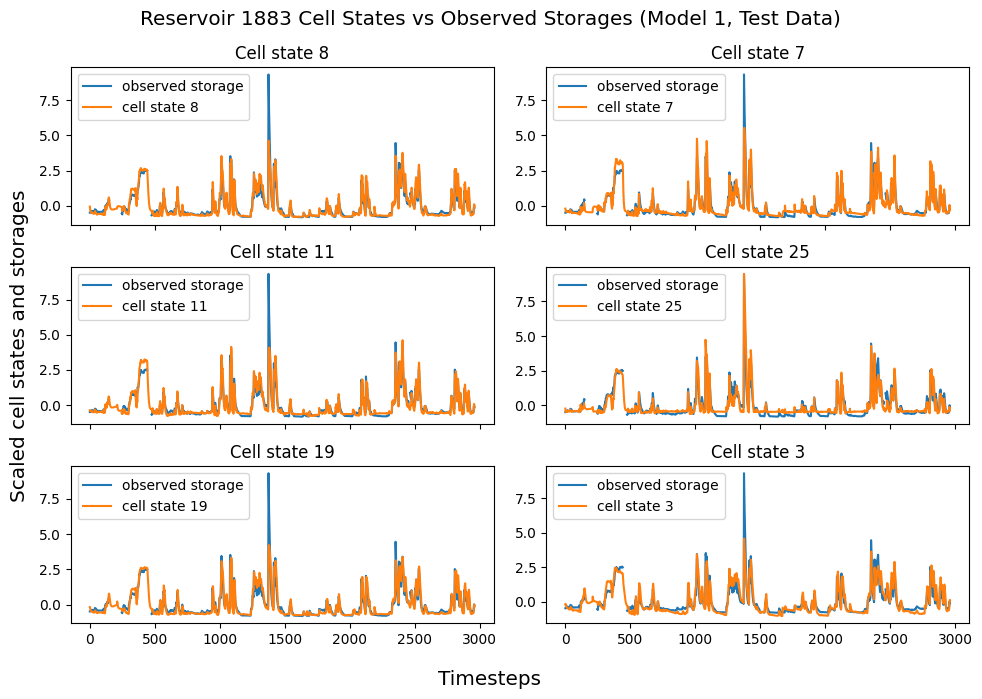

In [47]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 7), sharex=True)

cell_ids_list = [8, 7, 11, 25, 19, 3]
for i, ax in enumerate(axes.reshape(-1)):
    # ax.plot(((df_test.outflow - df_test.outflow.mean()) / df_test.outflow.std()).values, label='observed outflow')
    plot_storage_cell(cell_states_all=cell_test[0], storage_states=df_test.storage.values, cell_id=cell_ids_list[i], ax=ax)
    ax.legend(loc='upper left')
    ax.set_title(f'Cell state {cell_ids_list[i]}')

fig.supxlabel('Timesteps', size='x-large')
fig.supylabel('Scaled cell states and storages', size='x-large')
fig.suptitle('Reservoir 1883 Cell States vs Observed Storages (Model 1, Test Data)', size='x-large')
plt.tight_layout()
plt.show()

In [74]:
# Correlation between storage and outflow for 1883
stats.pearsonr(df_test.dropna(axis=0).outflow.values, df_test.dropna(axis=0).storage.values)[0]

np.float64(0.9686681250358141)

In [55]:
def correlate_storage_outflow():
    """Get pearson correlation between storage and outflow (test data) for each reservoir in res_list"""
    res_list = filter_res()
    left_years_dict = get_left_years(res_list=res_list)
    corrs = []
    for res in res_list:
        # Get split df data
        df_train, df_val, df_test = split_df_data(res_id=res, left=f'{left_years_dict[res]}-01-01', data_splits=(0.6, 0.2, 0.2))
        df_test.dropna(axis=0, inplace=True)
        corrs.append(stats.pearsonr(df_test.outflow.values, df_test.storage.values)[0])

    return pd.DataFrame(corrs, index=res_list, columns=['outflow_storage_corr'])

In [56]:
# Read inflow/outflow/storage for all ResOps reservoirs
df_inflow = pd.read_csv("data/ResOpsUS/time_series_single_variable_table/DAILY_AV_INFLOW_CUMECS.csv", 
                        parse_dates=True, index_col=0, dtype=np.float32)
df_outflow = pd.read_csv("data/ResOpsUS/time_series_single_variable_table/DAILY_AV_OUTFLOW_CUMECS.csv", 
                         parse_dates=True, index_col=0, dtype=np.float32)
df_storage = pd.read_csv("data/ResOpsUS/time_series_single_variable_table/DAILY_AV_STORAGE_MCM.csv", 
                         parse_dates=True, index_col=0, dtype=np.float32)
# Calculate mean inflow / max storage metric
df_result = pd.concat([df_inflow.mean(skipna=True), 
                       df_storage.max(),
                       correlate_storage_outflow()], axis=1, join='inner')
df_result.columns = ['mean_inflow', 'max_storage', 'outflow_storage_corr']
df_result['log_mean_in_max_out'] = np.log(df_result['mean_inflow'] / df_result['max_storage'])

# Join with max cell-storage correlations from Model 1/2
df_result = df_result.join(other=df_corr_max_test, how='inner')
df_result

,mean_inflow,max_storage,outflow_storage_corr,log_mean_in_max_out,Model1,Model2
1017,28.196121,553.226013,0.546620,-2.976582,0.681012,0.774112
1026,124.731316,4681.919922,0.635007,-3.625302,0.798921,0.658219
1036,183.351807,6802.357910,0.511446,-3.613618,0.777717,0.713543
1042,58.201374,2501.490967,0.452292,-3.760733,0.762670,0.715112
1067,50.235088,3465.172119,0.574168,-4.233804,0.508171,0.594386
...,...,...,...,...,...,...
920,41.242645,8.261000,0.345307,1.607927,0.328413,0.333695
938,1.417140,63.102001,0.199408,-3.796112,0.473221,0.445083
939,0.431045,49.077000,-0.358804,-4.734933,0.124599,0.161819
953,0.106396,50.449001,0.134862,-6.161549,0.088252,0.122770


In [57]:
def lobf(x, y, ax):
    """Plot line of best fit"""
    #Find line of best fit
    a, b = np.polyfit(x, y, 1)
    #Add line of best fit to plot
    ax.plot(x, a*x+b, color='red')
    return

def correlate(x, y):
    """Return pearson correlation"""
    return stats.pearsonr(x, y)[0]

def correlate_pval(x, y, alt='two-sided', n_resamples=10000):
    """
    Return pval testing significance of correlation coefficient using permutation testing
    Params:
    x, y: data arrays to calculate correlation between
    alt: str, 'greater', 'less', or 'two-sided'. The alternative hypothesis
    n_resamples: int, number of permutations used to approximate null distribution
    Return:
    r - float, Pearson's correlation between x and y
    pvalue - p-value from permutation testing
    """
    # Calculate correlation between x and y and permuation test p-value
    res = stats.permutation_test((x, y), correlate, vectorized=False,
                        permutation_type='pairings',
                        alternative=alt,
                        n_resamples=n_resamples,
                        random_state=0)
    r, pvalue, null = res.statistic, res.pvalue, res.null_distribution
    return r, pvalue

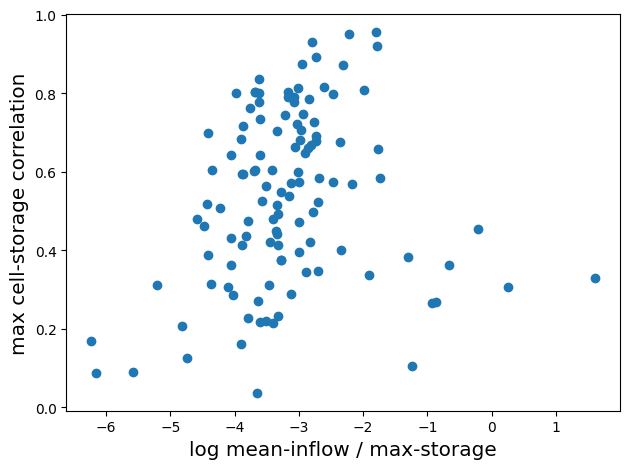

In [61]:
# Plot result
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True)
# log(mean inflow / max storage) ratio max storage is surrogate for capacity
x = df_result['log_mean_in_max_out']
# abs(LSTM cell-storage correlation)
y = np.abs(df_result['Model1'])
ax.scatter(x, y)
ax.set_xlabel('log mean-inflow / max-storage', size='x-large')
ax.set_ylabel('max cell-storage correlation', size='x-large')
plt.tight_layout()
plt.show()

c:\Users\mattc\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_resampling.py:1498: RuntimeWarning: overflow encountered in scalar power
  n_max = factorial(n_obs_sample)**n_samples


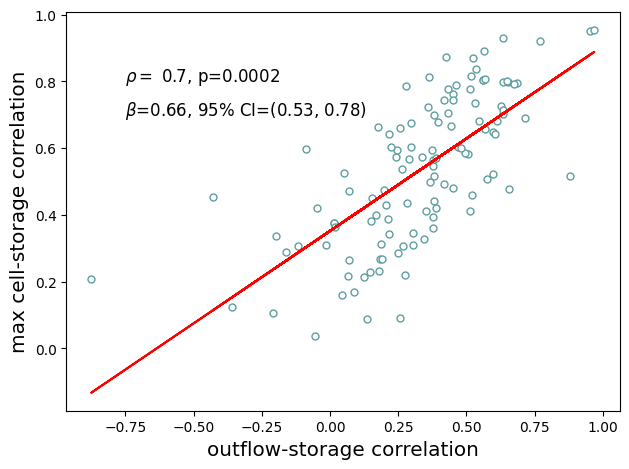

In [73]:
# Plot result
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True)
# log(mean inflow / max storage) ratio max storage is surrogate for capacity
x = df_result['outflow_storage_corr']
# abs(LSTM cell-storage correlation)
y = np.abs(df_result['Model1'])


ax.scatter(x, y, s=25, color='white', edgecolors='cadetblue')
# Add line of best fit
lobf(x, y, ax=ax) 
# Add correlation and p-value
corr, pval = correlate_pval(x, y)
ax.text(-0.75, 0.8, r'$\rho=$'+f' {round(corr, 2)}, p={round(pval, 6)}', size='large')
# Theil-Sen slope and 95 CI
slope, intercept, lo, hi = theilslopes(y, x, alpha=0.95)
ax.text(-0.75, 0.7, fr'$\beta$={round(slope, 2)}, 95% CI=({round(lo, 2)}, {round(hi, 2)})', size='large')


ax.set_xlabel('outflow-storage correlation', size='x-large')
ax.set_ylabel('max cell-storage correlation', size='x-large')
plt.tight_layout()
plt.show()